<a href="https://colab.research.google.com/github/MUMADE-TADM/s1_python-rdvicen1/blob/main/rnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[Yahoo finance](https://finance.yahoo.com/)

In [ ]:
!pip install -U yfinance pandas_datareader

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 50 kB 2.2 MB/s 
     |████████████████████████████████| 109 kB 9.2 MB/s 
     |████████████████████████████████| 4.1 MB 56.1 MB/s 
     |████████████████████████████████| 110 kB 53.8 MB/s 
     |████████████████████████████████| 112 kB 54.0 MB/s 
     |████████████████████████████████| 62 kB 1.0 MB/s 
     |████████████████████████████████| 128 kB 21.3 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: html5lib
    Found existing installation: html5lib 1.0.1
    Uninstalling html5lib-1.0.1:
      Successfully uninstalled html5lib-1.0.1
  Attempting uninstall: beautifulsoup4
    Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4

# Datos

Valor de cierre del IBEX

In [ ]:
import pandas as pd
import yfinance as yf
from pandas_datareader import data as pdr

In [ ]:
yf.pdr_override() # <== that's all it takes :-)
data = pdr.get_data_yahoo("^IBEX", start="2020-01-01", end="2020-10-30")

[*********************100%***********************]  1 of 1 completed


## [Bollinger Bands](https://en.wikipedia.org/wiki/Bollinger_Bands)

El 97% de los valores de un activo se encuentran entre un máximo de $+1.96 \times  \sigma(20\ valores\ anteriores)$ y $-1.96 \times \sigma(20\ valores\  anteriores)$ centrados en la media de los 20 valores anteriores.

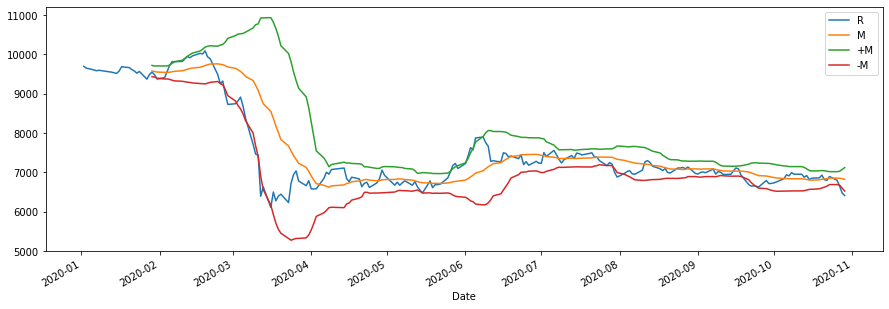

In [ ]:
d=pd.DataFrame()
d['R']=data['Close']
d['M']=data['Close'].rolling(20).mean()
d['+M']=d['M']+data['Close'].rolling(20).std()*1.96
d['-M']=d['M']-data['Close'].rolling(20).std()*1.96
d.plot(figsize=(15,5))

## Transformación de los datos para un problema de regresión / clasificación
- Datos originales $[c_0,\ldots,c_T]$
- Datos transformados:$[[c_0,\ldots,c_{19}],c_{20}],\ldots,[[c_{T-20},\ldots,c_{T-1}],c_T]$.

In [ ]:
def windowData(s,window_input=1,window_output=1,step=1):
  X=[]
  Y=[]
  #Datos necesarios
  dn=window_input+window_output
  #Calcular cuantos pasos completos podemos realizar
  #sin contar el último bloque [input,output]
  ld=int((len(s)-dn)/step)*step
  for i in range(len(s)-ld-1,len(s)-dn,step):
    X.append(s[i:i+window_input])
    Y.append(s[i+window_input:i+dn])
  return X,Y

In [ ]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

#Escalanos los datos
dScale = MinMaxScaler()
ldatos=d['R'].values #ldatos.shape=(len(d['R']),)
ldatos=ldatos.reshape((len(d['R']),1)) #ldatos.shape=(len(d['R']),1)
dScale.fit(ldatos)
ldatos=dScale.transform(ldatos).reshape((len(ldatos),))

#Contruimos los conjunto de datos X e Y
X,Y=windowData(ldatos,window_input=20,window_output=1,step=1)
X=np.array(X)
Y=np.array(Y)

#partmos los conjuntos en entranamiento y test
X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.33,shuffle=False, random_state=42)

In [ ]:
X.shape

(172, 20)

## Ajustamos los datos 
Los datos en las **redes recurrentes** son tensores de 3 dimensiones
\[número de ejemplos por batch, tamaño del paso, número de características \]

**\[size,step,features\]**

Consideramos un **step** de 20 con una única **característica**


en las recurrentes el tamaño tiene que ser el tamaño del dataset

pasos -> elemento que vamos a utilizar en el recurrente (20,30,40...)

feature -> cantida de parametros

In [ ]:
XRNN=X.reshape((X.shape[0],X.shape[1],1))
XRNN.shape

(172, 20, 1)

20 = pasos

## Librerías necesarias 
- [Keras](https://keras.io/)
- [Tensorflow](https://www.tensorflow.org/)

modelo secuencial, donde salida de 1 vaya a la entrada de otra

In [ ]:
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Input,SimpleRNN
from tensorflow.keras import metrics

## Definir la Red

Definimos nuestro perceptron con las siguientes capas (**layers**)
- Modelo secuencial [Sequential](https://keras.io/api/models/sequential/)
- Capa de entrada: [SimpleRNN](https://keras.io/api/layers/recurrent_layers/simple_rnn/)
- Capa Densa: [Dense](https://keras.io/api/layers/core_layers/dense/) 

La capa **SimpleRNN** define una unidad recurente con **unit** neuronas de salida y una entrada de **input_shape**

**Recurrente básica**

se va añadiendo capas, en este caso 1 solo de 32 unidades, unidades = neuronas que vuelvan alimentadas; entrada de 20,,1



optimizador rmsprop

In [ ]:
rnn = Sequential()
rnn.add(SimpleRNN(units=32, activation="relu",input_shape=(20,1)))
rnn.add(Dense(1))
rnn.compile(loss='mean_squared_error', optimizer='rmsprop')
rnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 32)                1088      
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 1,121
Trainable params: 1,121
Non-trainable params: 0
_________________________________________________________________


los va 1088 parametros

## Compilar la red
Definido el **perceptrón** lo tendremos que compilar indicando:
- Que optimizador utilizar.
- Que función de error (pérdida o **loss**).
- Que métricas observar cuando lo entrenemos.

Función [**compile**](https://keras.io/api/models/model_training_apis/#compile-method)

en cada epoca nos va indicando el error que va cometiendo

In [ ]:
h=rnn.fit(XRNN,Y,validation_split=0.30, epochs=100,batch_size=5)

Epoch 1/100
24/24 [==============================] - 3s 43ms/step - loss: 0.0488 - val_loss: 0.0011
Epoch 2/100
24/24 [==============================] - 0s 14ms/step - loss: 0.0076 - val_loss: 0.0020
Epoch 3/100
24/24 [==============================] - 0s 14ms/step - loss: 0.0062 - val_loss: 0.0013
Epoch 4/100
24/24 [==============================] - 0s 12ms/step - loss: 0.0051 - val_loss: 0.0013
Epoch 5/100
24/24 [==============================] - 0s 16ms/step - loss: 0.0042 - val_loss: 6.8903e-04
Epoch 6/100
24/24 [==============================] - 0s 11ms/step - loss: 0.0039 - val_loss: 7.2291e-04
Epoch 7/100
24/24 [==============================] - 0s 13ms/step - loss: 0.0035 - val_loss: 0.0013
Epoch 8/100
24/24 [==============================] - 0s 13ms/step - loss: 0.0032 - val_loss: 0.0010
Epoch 9/100
24/24 [==============================] - 0s 12ms/step - loss: 0.0030 - val_loss: 5.2118e-04
Epoch 10/100
24/24 [==============================] - 0s 14ms/step - loss: 0.0028 - val_

perdida de 0,04, valor de perdida va disminuyendo a mitad de n. epocas(50)

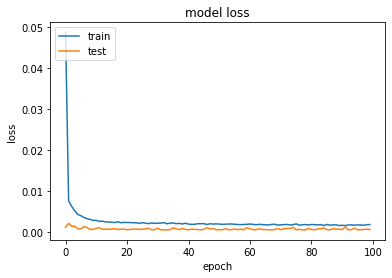

In [ ]:
import matplotlib.pyplot as plt
plt.plot(h.history['loss'])
plt.plot(h.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Utilizar la red
Utilizar el perceptron aprendido con el método [**predict**](https://keras.io/api/models/model_training_apis/#predict-method)

In [ ]:
Y0=rnn.predict(XRNN)

6/6 [==============================] - 0s 6ms/step


perceptron no tiene memoria(informacion del pasado)

en cambio redes recurrentes si tienen concepto del pasado

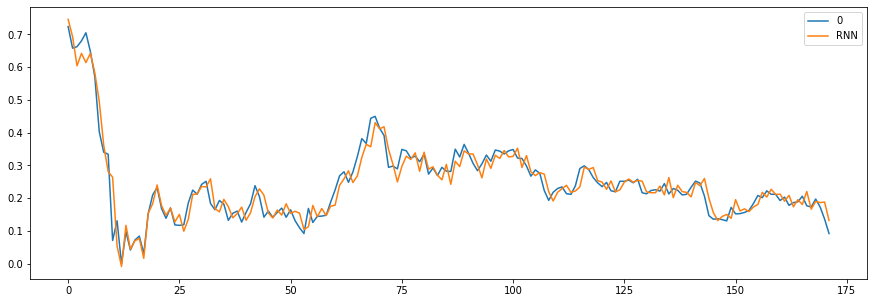

In [ ]:
r=pd.DataFrame(Y)
r['RNN']=pd.DataFrame(Y0)
r.plot(figsize=(15,5))

## Salvar y Cargar Redes
- Salvar mediante el método [**save**](https://keras.io/api/models/model_saving_apis/#save-method).
- Recuperar un modelo con el método [**load_model**](keras.models.load_model).

In [ ]:
rnn.save('rnn.h5')
rnn2=keras.models.load_model('rnn.h5')